In [ ]:
import geohash
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS



In [ ]:
data_set = pd.read_csv('data_set.csv', header=None)

# 时间的格式为: 2017-05-15 17:37:54
# 将数据按照time进行分类
data_set = np.array(data_set)
data_in_hour = {}
for el in data_set[1:]:
    el_time = el[4].split('-')
    day = int(el_time[2].split(' ')[0])
    hour = int(el_time[2].split(' ')[1].split(':')[0])
    hours = day * 24 + hour
    if hours not in data_in_hour:
        data_in_hour[hours] = []
    else:
        data_in_hour[hours].append(el)

# save the data in each hour to csv file
for key in data_in_hour:
    data_in_hour[key] = pd.DataFrame(data_in_hour[key])
    data_in_hour[key].to_csv('data\data_in_hour'+str(key)+'.csv')
        
print(data_in_hour.keys())
    

In [ ]:
import geohash
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('data\data_in_hour'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time)
    data_at_time = data_at_time[1:, 6:8]
    
    start_pos = []
    end_pos = []
    
    for each_data in data_at_time:
        start_pos.append(geohash.decode(each_data[0]))
        end_pos.append(geohash.decode(each_data[1]))
    
    # save position to csv file
    pd.DataFrame(start_pos).to_csv('start_pos\\startpos'+str(i)+'.csv')
    pd.DataFrame(end_pos).to_csv('end_pos\\endpos'+str(i)+'.csv')
    

In [ ]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=300, xi=0.01, min_cluster_size=None)

for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('start_pos\\startpos'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
        
    try:
        cluster_labels = optics.fit_predict(data_at_time)
    except:
        continue
    # remove the -1 label and the corresponding data
    data_at_time = data_at_time[cluster_labels != -1]
    cluster_labels = cluster_labels[cluster_labels != -1]
    
    plt.scatter(data_at_time[:,0], data_at_time[:,1], c=cluster_labels)
    plt.savefig('after_cluster\position_area'+str(i)+'.png')
    

由上聚类可估计城区范围(39.5, 116.0)~(40.2,116.8)

In [ ]:
# 按照城区范围将城区分为50*50的网格
# 城区范围(39.5, 116.0)~(40.2,116.8)
time_heatmap = []
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('start_pos\\startpos'+str(i)+'.csv', header=None)
    except:
        continue
    # 将范围外的点去除
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
    data_at_time = data_at_time[data_at_time[:,0] <= 40.2]
    data_at_time = data_at_time[data_at_time[:,0] >= 39.5]
    data_at_time = data_at_time[data_at_time[:,1] <= 116.8]
    data_at_time = data_at_time[data_at_time[:,1] >= 116.0]
    # 将经纬度转换为网格坐标
    data_at_time[:,0] = (data_at_time[:,0] - 39.5) / 0.7 * 50
    data_at_time[:,1] = (data_at_time[:,1] - 116.0) / 0.8 * 50
    # 计算heatmap
    heatmap = np.zeros((50, 50))
    for each_data in data_at_time:
        heatmap[int(each_data[0]), int(each_data[1])] += 1
    # 保存heatmap为png
    plt.imshow(heatmap)
    plt.savefig('heatmap_start\heatmap_start'+str(i)+'.png')
    
    time_heatmap.append(heatmap)

time_heatmap = np.array(time_heatmap)
np.savetxt('time_heatmap_start.csv', time_heatmap.reshape(-1), delimiter=',')

time_heatmap = []
# 计算结束位置
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('end_pos\\endpos'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
    data_at_time = data_at_time[data_at_time[:,0] <= 40.2]
    data_at_time = data_at_time[data_at_time[:,0] >= 39.5]
    data_at_time = data_at_time[data_at_time[:,1] <= 116.8]
    data_at_time = data_at_time[data_at_time[:,1] >= 116.0]
    
    data_at_time[:,0] = (data_at_time[:,0] - 39.5) / 0.7 * 50
    data_at_time[:,1] = (data_at_time[:,1] - 116.0) / 0.8 * 50
    
    heatmap = np.zeros((50, 50))
    for each_data in data_at_time:
        heatmap[int(each_data[0]), int(each_data[1])] += 1
    
    plt.imshow(heatmap)
    plt.savefig('heatmap_end\heatmap_end'+str(i)+'.png')
    
    time_heatmap.append(heatmap)

time_heatmap = np.array(time_heatmap)
np.savetxt('time_heatmap_end.csv', time_heatmap.reshape(-1), delimiter=',')
    

In [ ]:
# load heatmap from csv
time_heatmap = np.loadtxt('time_heatmap.csv', delimiter=',').reshape(-1, 50, 50)

plt.imshow(time_heatmap[1])

In [ ]:
time_heatmap_start = np.loadtxt('time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt('time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

# 初始状态每个地区的储量为10
store_amount = np.ones((50, 50)) * 10

import seaborn as sns
# 模拟自行车的迁移过程, 绘制高度图
for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount = store_amount - start + end
    sns.heatmap(store_amount, vmin=-1000, vmax=1000, cmap='RdBu_r')
    plt.savefig('store_amount\store_amount'+str(i)+'.png')
    plt.clf()
    

In [ ]:
from matplotlib import animation

# plot gif
fig = plt.figure()
ims = []
for i in range(356):
    try:
        # read from file
        im = plt.imread('store_amount\store_amount'+str(i)+'.png')
    except:
        continue
    ims.append([plt.imshow(im)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#AttributeError: 'numpy.ndarray' object has no attribute 'set_visible'
ani.save('store_amount.gif', writer='imagemagick', fps=10)

先以自行车的利用率为指标进行计算
$$利用率 = \frac{利用的自行车数}{总的自行车数}$$


C:\Users\12721\AppData\Local\Temp\ipykernel_21524\2297173127.py:28: RuntimeWarning: invalid value encountered in double_scalars
  used_rate.append(np.sum(used) / sum_num)


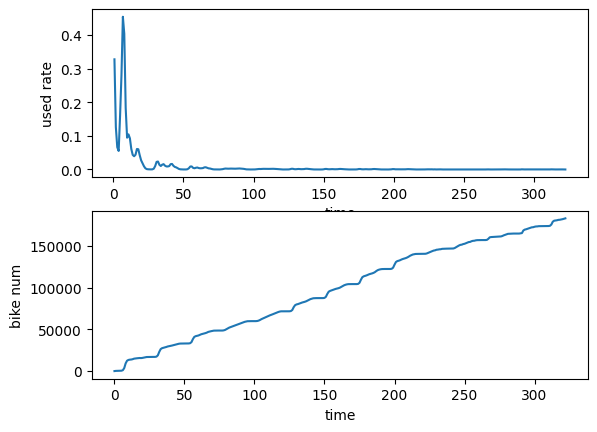

In [46]:
import numpy as np
import matplotlib.pyplot as plt

time_heatmap_start = np.loadtxt('time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt('time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

# 初始状态每个地区的储量
store_amount = []
store_amount.append(np.ones((50, 50)) * 0)

import seaborn as sns
# 模拟自行车的迁移过程
for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount.append(store_amount[i] - start + end)
    
# 计算不同时间的自行车利用率
sum_num = 0
bike_num = []
used_rate = []
for i, (need, stored) in enumerate(zip(time_heatmap_start, store_amount)):
    # 去store_amount除负值
    bike_num.append(np.sum(stored[stored < 0]) * -1)
    sum_num += np.sum(stored[stored < 0]) * -1
    stored[stored < 0] = 0
    
    # 取need和stored中的较小值
    used = np.minimum(need, stored)
    used_rate.append(np.sum(used) / sum_num)

plt.subplot(211)
plt.plot(used_rate)
plt.xlabel('time')
plt.ylabel('used rate')
plt.subplot(212)
plt.plot(bike_num)
plt.xlabel('time')
plt.ylabel('bike num')
plt.show()    
    

由上图可知, 如果不对已有的单车进行调度, 则需要不断引入新的单车来满足需求, 且对现有单车的利用率会一直很低, 所以我们需要考虑一种调度策略来提高利用率, 减少单车引入量

为了对调度算法有一个合理的估计, 我们先求出理论最优的调度方案, 即已经存在的单车可以全部得到利用的情况下的单车引入量

33577.0


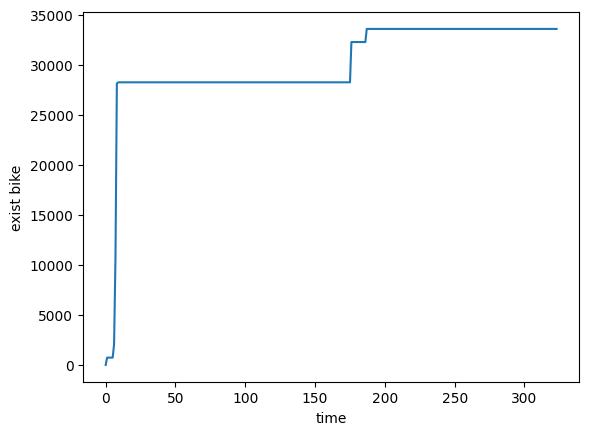

In [54]:
exist_bike = [0]
for i, stored in enumerate(time_heatmap_start):
    exist_bike.append(max(exist_bike[i], np.sum(stored)))
    
print(exist_bike[-1])

plt.plot(exist_bike)
plt.xlabel('time')
plt.ylabel('exist bike')
plt.show()

In [2]:
# 指数加权平均
def ewma(x, alpha):
    y = [x[0]]
    for i in range(1, len(x)):
        y.append(alpha *  y[i-1] + (1 - alpha) * x[i])
    return y

理论最优只需要33577辆车就可以满足需求

## 方案一: 范围搜索调度(红包车调度)
如果一个点缺少自行车, 先按照广度优先搜索, 搜索一定范围内的自行车储存, 如果储存量够, 则优先从此调度自行车, 否则从外界引入新的自行车
这个调度过程可以分配给用户完成, 一个缺少自行车的区域向周围多出来的自行车区域寻求调度, 等同于准备将自行车停入周围区域的用户将自行车改变目的地到缺少自行车的区域, 从而实现自行车的调度

所以这个向周围区域寻求调度的过程, 可以转化为向周围骑行用户发放红包, 使其骑行到缺失点的一个方案

[0.0, 0.0447187922535145, 0.07088986746533193, 0.08979267242889735, 0.11679151686893358, 0.20497575179592836, 0.2845266727363719, 0.35608337919725913, 0.41415771748582975, 0.4169887309846827, 0.4053051820150654, 0.4094478598810273, 0.42113815949068756, 0.418917074556379, 0.40826329100265396, 0.39960765947312255, 0.40314412850365783, 0.4404464789028034, 0.48126475113482464, 0.4942429174916118, 0.4865388053991732, 0.46772688126256917, 0.43746059805512566, 0.4000895174522832, 0.3624661920579497, 0.3272709786079187, 0.2951860367941599, 0.26626633512752085, 0.24057465420138166, 0.2230152756198733, 0.23432213267488533, 0.3003558984160589, 0.35769399604775093, 0.3661072855813108, 0.36228742255477925, 0.37382100064585877, 0.39293453733197964, 0.3956565671173437, 0.3907538593855461, 0.38876556544729096, 0.3945864010479785, 0.4335834454939726, 0.47634467503593664, 0.4856840250536799, 0.4789034963702476, 0.4659325885336348, 0.4404576668739318, 0.4051180670518917, 0.36779917514679633, 0.3320192903

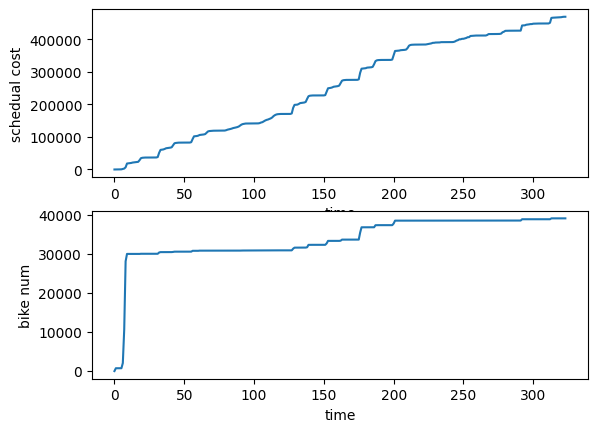

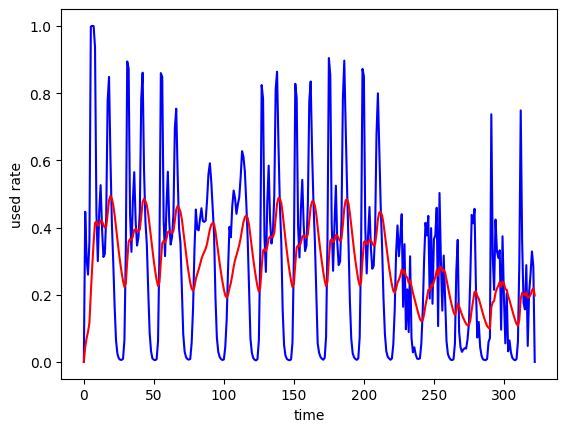

In [5]:

import numpy as np
import matplotlib.pyplot as plt

time_heatmap_start = np.loadtxt(
    'time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt(
    'time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)


def get_bike_from_ranged_store(stored, x, y):
    visited = np.zeros((50, 50))
    search_queue = [(x, y, 0)]
    schedual_cost = 0

    while search_queue and stored[x, y] < 0:
        x_s, y_s, searching_deep = search_queue.pop(0)
        for x_n, y_n in [(x_s-1, y_s), (x_s+1, y_s), (x_s, y_s-1), (x_s, y_s+1)]:
            if x_n < 0 or x_n >= 50 or y_n < 0 or y_n >= 50:
                continue
            if visited[x_n, y_n] == 0:
                search_queue.append((x_n, y_n, searching_deep+1))
                visited[x_n, y_n] = 1
        if searching_deep > 5:
            break
        if stored[x_s, y_s] <= 0:
            continue
        move_num = min(stored[x_s, y_s], -stored[x, y])
        stored[x_s, y_s] -= move_num
        stored[x, y] += move_num
        schedual_cost += move_num * searching_deep

    return stored, schedual_cost


store_amount_case_1 = []
store_amount_case_1.append(np.ones((50, 50)) * 0)

bike_num = [0]
schedual_cost_list = [0]
used_rate = []

for i, (need, moved) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    stored = store_amount_case_1[i].copy() - need

    cost_all = 0

    for x, y in np.argwhere(stored < 0):
        stored, schedual_cost = get_bike_from_ranged_store(stored, x, y)
        cost_all += schedual_cost

    bike_num.append(bike_num[i] + np.sum(stored[stored < 0]) * -1)
    stored[stored < 0] = 0

    stored += moved
    schedual_cost_list.append(schedual_cost_list[i] + cost_all)

    used_rate.append((np.sum(need) - (bike_num[i+1] - bike_num[i])) / (bike_num[i] + 0.00001))

    store_amount_case_1.append(stored)

used_rate_ewma = ewma(used_rate, 0.9)
print(used_rate_ewma)

plt.subplot(211)
plt.plot(schedual_cost_list)
plt.xlabel('time')
plt.ylabel('schedual cost')
plt.subplot(212)
plt.plot(bike_num)
plt.xlabel('time')
plt.ylabel('bike num')

plt.show()
plt.plot(used_rate, 'b')
plt.xlabel('time')
plt.ylabel('used rate')
plt.plot(used_rate_ewma, 'r')
plt.show()

## 方案2: 车辆集中调度
通过将50*50的栅格建立成一个图, 我们的问题可以抽象为图上问题, 有一个图, 每个节点上有一个整数(可负), 我们可以将一个节点上的值减去x并加到相邻的某个节点上, 并且产生x的成本, 现在需要所有节点都为非负, 操作使得成本最小

这问题可以当作一个最小费用最大流问题

In [23]:

import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_flow, csgraph_from_dense, floyd_warshall




[(0, 0), (1, -15), (2, -4), (3, -15), (4, -8), (5, 11), (6, 8), (7, 4), (8, 10), (9, 11)]


TypeError: 'numpy.ndarray' object is not callable

接下来我们尽量在该成本下寻求可行调度方案

In [ ]:
time_heatmap_start = np.loadtxt(
    'time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt(
    'time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount.append(store_amount[i] - start + end)
    